# Predicting Flight Fares with XGBoost Regression

## Introduction
The primary objective of this project is to build a predictive model that can accurately estimate flight fares based on various features such as time of booking, airline and class, departure and arrival times, and other relevant factors. By analyzing patterns in flight fares over time, the aim is to provide users with insights that can help them make informed decisions about purchasing flight tickets, potentially saving money in the process, as well as uncover interesting patterns in airfare pricing in India.

## Dataset Summary
The dataset contains flight fare data collected from the top 7 busiest airports in India. It was collected using a Python script with Beautiful Soup and Selenium libraries. The scraping process collected information on flight details including departure and arrival times, airline and class, duration, total stops, and price. 

- **Link:** [Flight Fare Dataset](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares/data)

In [2]:
# Import Python libraries 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, OneHotEncoder, Normalizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold,cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# Read in the dataset
df = pd.read_csv('/kaggle/input/airfare-ml-predicting-flight-fares/Cleaned_dataset.csv')

# Display the shape of the dataset
print(df.shape)

# Display the first few rows of the dataset
print(df.head())

#Set pallete for plots
sns.set_palette("coolwarm")

(452088, 13)
  Date_of_journey Journey_day    Airline Flight_code    Class Source  \
0      2023-01-16      Monday   SpiceJet     SG-8169  Economy  Delhi   
1      2023-01-16      Monday     Indigo     6E-2519  Economy  Delhi   
2      2023-01-16      Monday   GO FIRST      G8-354  Economy  Delhi   
3      2023-01-16      Monday   SpiceJet     SG-8709  Economy  Delhi   
4      2023-01-16      Monday  Air India      AI-805  Economy  Delhi   

    Departure Total_stops      Arrival Destination  Duration_in_hours  \
0  After 6 PM    non-stop   After 6 PM      Mumbai             2.0833   
1  After 6 PM    non-stop  Before 6 AM      Mumbai             2.3333   
2  After 6 PM    non-stop  Before 6 AM      Mumbai             2.1667   
3  After 6 PM    non-stop   After 6 PM      Mumbai             2.0833   
4  After 6 PM    non-stop   After 6 PM      Mumbai             2.1667   

   Days_left  Fare  
0          1  5335  
1          1  5899  
2          1  5801  
3          1  5794  
4         

# Exploratory Data Analysis (EDA)

## Dataset Overview
- The dataset comprises 452,088 entries across 13 columns, including features such as date of journey, airline, flight code, class, source, departure time, total stops, arrival time, destination, duration in hours, days left before travel, and fare.

## Summary Statistics
- **Duration_in_hours:** 
  - The average duration of flights is approximately 12.35 hours, with a standard deviation of 7.43 hours. The shortest flight lasts 45 minutes, while the longest flight spans over 43.5 hours. The distribution of flight durations suggests a wide range of travel times, from short flights to long-haul journeys.
- **Days_left:** 
  - On average, flights are booked about 25.63 days in advance, with a standard deviation of 14.30 days. The shortest booking window is just 1 day, while the longest is 50 days.
- **Fare:** 
  - The mean fare for flights in the dataset is ₹22,840.10, with a considerable standard deviation of ₹20,307.96. Fares range from as low as ₹1,307 to as high as ₹143,019. Prices exhibit significant variability, with fares ranging from budget-friendly to premium rates. Understanding the factors influencing fare prices will be crucial for accurate prediction.

In [3]:
# Display summary statistics
print(df.describe())

# Display information about the dataset
print(df.info())

# Display the count of unique values in each categorical feature
print(df.select_dtypes(include='object').nunique())

# Drop the 'Flight_code' and 'Date_of_journey' columns
df = df.drop(columns=['Flight_code'])
print(df.head())

       Duration_in_hours      Days_left           Fare
count      452088.000000  452088.000000  452088.000000
mean           12.349222      25.627902   22840.100890
std             7.431478      14.300846   20307.963002
min             0.750000       1.000000    1307.000000
25%             6.583300      13.000000    8762.750000
50%            11.333300      26.000000   13407.000000
75%            16.500000      38.000000   35587.000000
max            43.583300      50.000000  143019.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_of_journey    452088 non-null  object 
 1   Journey_day        452088 non-null  object 
 2   Airline            452088 non-null  object 
 3   Flight_code        452088 non-null  object 
 4   Class              452088 non-null  object 
 5   Source             452088 non-null  object 
 6

In [4]:
# Convert to 'category' data type
categorical_columns = ['Airline', 'Class', 'Source', 'Departure', 'Total_stops', 'Arrival', 'Destination', 'Journey_day']
df[categorical_columns] = df[categorical_columns].astype('category')

# Display the data types after conversion
print(df[categorical_columns].dtypes)
print(df.dtypes)

# Convert 'Date_of_journey' column to datetime data type
df['Date_of_journey'] = pd.to_datetime(df['Date_of_journey'])

# Extract month and store it in a new column
df['Journey_month'] = df['Date_of_journey'].dt.month

# Drop the 'Date_of_journey' column
df = df.drop(columns=['Date_of_journey'])

Airline        category
Class          category
Source         category
Departure      category
Total_stops    category
Arrival        category
Destination    category
Journey_day    category
dtype: object
Date_of_journey        object
Journey_day          category
Airline              category
Class                category
Source               category
Departure            category
Total_stops          category
Arrival              category
Destination          category
Duration_in_hours     float64
Days_left               int64
Fare                    int64
dtype: object


As can be seen from the statistics below, there is a notable disparity between the median and mean values of the target variable 'Fare', indicating a wide spread in the dataset. This suggests a significant variability or dispersion in the fare prices.

In [5]:
# Display summary statistics 
print(df.describe())

# Display the median values for numeric columns
print(df[['Duration_in_hours', 'Days_left', 'Fare']].median())

       Duration_in_hours      Days_left           Fare  Journey_month
count      452088.000000  452088.000000  452088.000000  452088.000000
mean           12.349222      25.627902   22840.100890       1.804730
std             7.431478      14.300846   20307.963002       0.629704
min             0.750000       1.000000    1307.000000       1.000000
25%             6.583300      13.000000    8762.750000       1.000000
50%            11.333300      26.000000   13407.000000       2.000000
75%            16.500000      38.000000   35587.000000       2.000000
max            43.583300      50.000000  143019.000000       3.000000
Duration_in_hours       11.3333
Days_left               26.0000
Fare                 13407.0000
dtype: float64


 ## Exploration of Target Variable
 
The variable 'Fare' exhibits right-skewness and displays signs of multimodality.

- **Interquartile Range:** The IQR of the fare distribution is 26824.25.

- **Number of Outliers:** There are 9245 outliers above the third quartile (Q3). However the proportion in the entire dataset is only 2.04%.

These findings confirm the initial insights and show need to account for the distribution's characteristics when applying transformations and choosing modeling techniques.

In [6]:
# Custom function for calculating IQR and identifying outliers
def iqr_outliers(df, column):
    '''
    Calculate IQR and identify outliers for a specific column
    
    Calculates the Interquartile Range (IQR) of the specified column in the DataFrame and identifies the number of outliers based on the IQR method.
    
    '''
    # Check if the column exists in the DataFrame
    if column not in df.columns:
        print(f"Column '{column}' does not exist in the DataFrame.")
        return None, None, None, None

    # Check if the DataFrame is empty
    if df.empty:
        print("DataFrame is empty.")
        return None, None, None, None

    # Calculate the IQR of the column
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    print(f"IQR: {iqr}")

    # Identify lower outliers below q1 - 1.5 * iqr and upper outliers above q3 + 1.5 * iqr
    lower_outliers = df[df[column] < q1 - 1.5 * iqr]
    upper_outliers = df[df[column] > q3 + 1.5 * iqr]
    
    # Calculate the number of lower outliers and upper outliers
    num_lower_outliers = len(lower_outliers)
    num_upper_outliers = len(upper_outliers)
    num_total_outliers = num_lower_outliers + num_upper_outliers
    print(f"Number of lower outliers: {num_lower_outliers}")
    print(f"Number of upper outliers: {num_upper_outliers}")
    print(f"Total number of outliers: {num_total_outliers}")

    # Calculate proportion of outliers in the dataset
    proportion_outliers = num_total_outliers / len(df) * 100
    print(f"Proportion of outliers in the dataset: {proportion_outliers:.2f}%")
    
    return lower_outliers, upper_outliers, num_total_outliers


In [7]:
iqr_outliers(df, 'Fare')

IQR: 26824.25
Number of lower outliers: 0
Number of upper outliers: 9245
Total number of outliers: 9245
Proportion of outliers in the dataset: 2.04%


(Empty DataFrame
 Columns: [Journey_day, Airline, Class, Source, Departure, Total_stops, Arrival, Destination, Duration_in_hours, Days_left, Fare, Journey_month]
 Index: [],
        Journey_day  Airline     Class     Source     Departure Total_stops  \
 356         Monday  Vistara  Business      Delhi    After 6 PM      1-stop   
 357         Monday  Vistara  Business      Delhi  6 AM - 12 PM      1-stop   
 358         Monday  Vistara  Business      Delhi   Before 6 AM      1-stop   
 359         Monday  Vistara  Business      Delhi    After 6 PM      1-stop   
 360         Monday  Vistara  Business      Delhi  12 PM - 6 PM      1-stop   
 ...            ...      ...       ...        ...           ...         ...   
 451502    Thursday  Vistara  Business  Ahmedabad   Before 6 AM      1-stop   
 451503    Thursday  Vistara  Business  Ahmedabad  6 AM - 12 PM      1-stop   
 451607      Friday  Vistara  Business  Ahmedabad  6 AM - 12 PM      1-stop   
 451608      Friday  Vistara  Busine

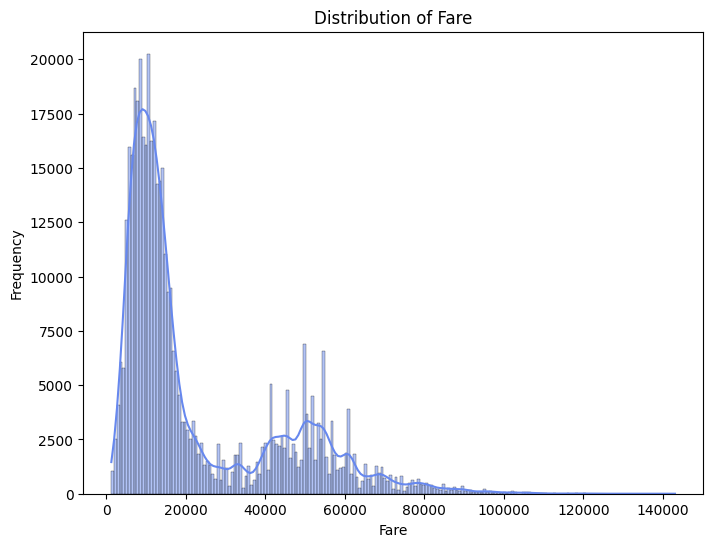

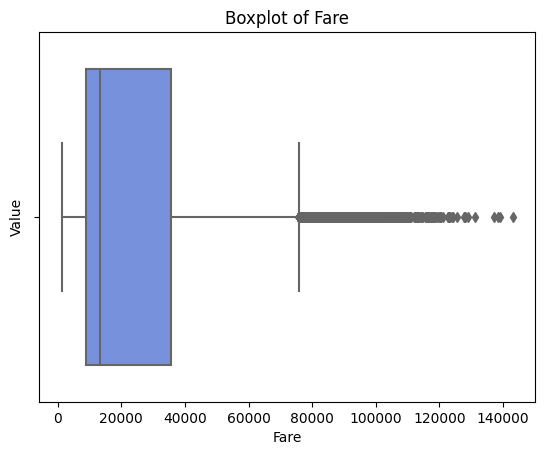

In [8]:
#Visualize the distribution of Fare
plt.figure(figsize=(8, 6))
sns.histplot(df['Fare'], kde=True)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

# Create a boxplot 'Fare'
sns.boxplot(data=df, x='Fare')
plt.title('Boxplot of Fare')
plt.xlabel('Fare')
plt.ylabel('Value')
plt.show()

## Exploration of Categorical Columns
Upon examining the categorical columns, we gain insights into the distribution of different classes within each feature.

Features such as 'Day_of_Journey', as well as 'Source' and 'Destination' have a roughly equal representation of classes within each category. In contrast, the ccolumns representing airlines and class demonstrate imbalanced distributions. Some airlines or classes may dominate the dataset, while others are less represented.

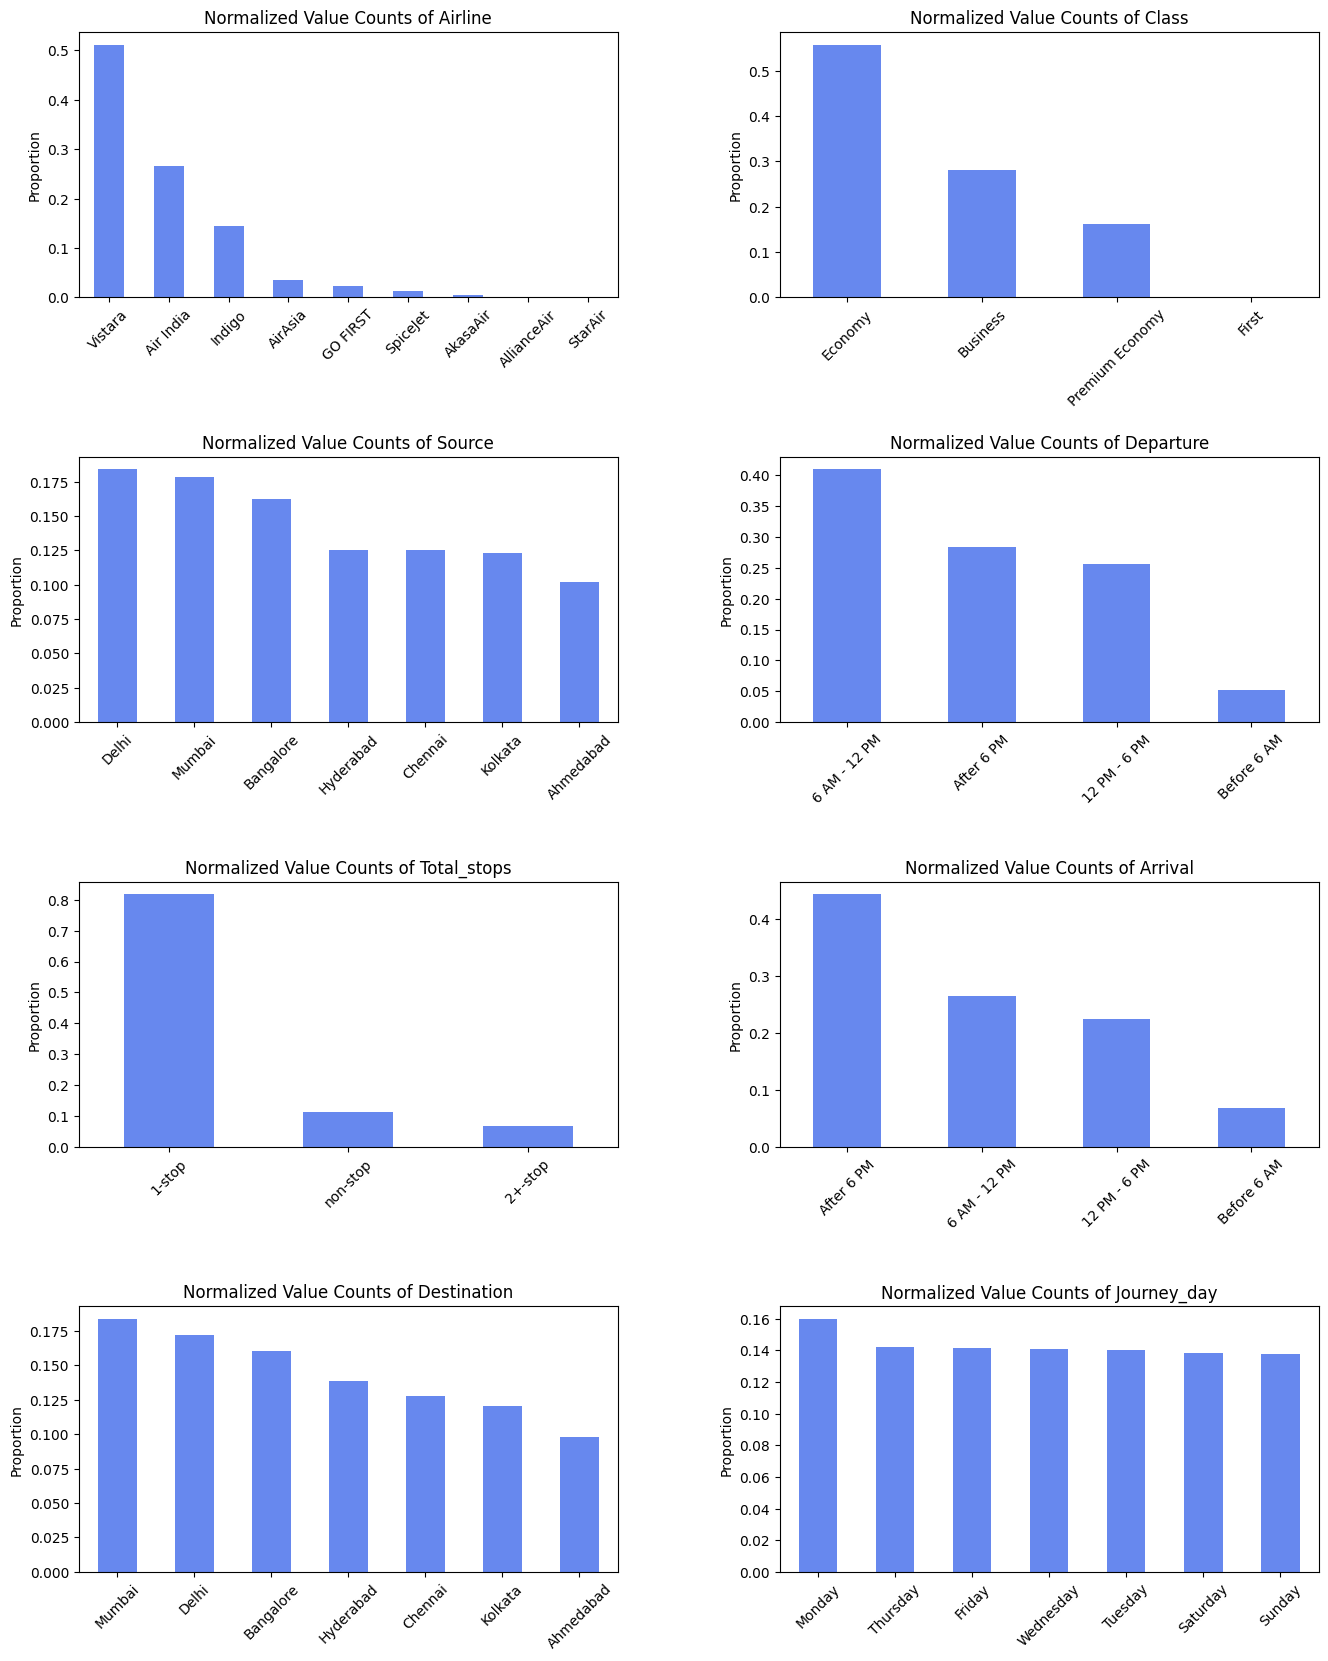

In [9]:
# Loop through each categorical column, calculate normalized value counts, and plot bar charts

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    value_counts_norm = df[col].value_counts(normalize=True)
    value_counts_norm.plot(kind='bar', ax=ax)
    ax.set_title(f'Normalized Value Counts of {col}')
    ax.set_xlabel(None)
    ax.set_ylabel('Proportion')
    ax.set_xticklabels(value_counts_norm.index, rotation=45)
    
plt.show()

After examining the 'Journey_month' column, it was observed that the dataset contains data for only three months, with February contributing to over half of the records. Due to the limited variation in months and the dominance of February data, it was decided to drop the 'Journey_month' column.


In [10]:
# Display the normalized value counts of 'Journey_month' 
print(df['Journey_month'].value_counts(normalize=True))
# Drop the 'Journey_month' column based on the analysis
df = df.drop(columns=['Journey_month'])

Journey_month
2    0.565343
1    0.314963
3    0.119694
Name: proportion, dtype: float64


In the categorical feature 'Airline', four of the least represented airlines were merged into a single category named 'Other'. This process helps to reduce the dimensionality of the dataset and create a more balanced representation of airlines.

In [11]:
# Replace rare Airline categories with 'Other'
rare_airlines = ['AkasaAir', 'AllianceAir', 'StarAir', 'SpiceJet']
df['Airline'] = df['Airline'].apply(lambda x: 'Other' if x in rare_airlines else x)

# Check the value counts after grouping
print(df['Airline'].value_counts())

Airline
Vistara      231490
Air India    119841
Indigo        65659
AirAsia       15764
GO FIRST      10786
Other          8548
Name: count, dtype: int64


# Visualization of Numerical Variables

To understand the distribution and characteristics of numerical variables in the dataset, histograms and boxplots were plotted for 'Duration_in_hours' and 'Days_left'.

- **Duration_in_hours** has right-skewed distribution with signs of multimodality. Outliers are visible in the upper range of the duration values.
  
- **Days_left** has a distribution that is close to unimodal, with no apparent outliers.

The decision was made not to trim outliers from both the 'Fare' and 'Duration_in_hours' features. This choice was based on the recognition that these outliers are not anomalies but rather integral components of the airfare market data.

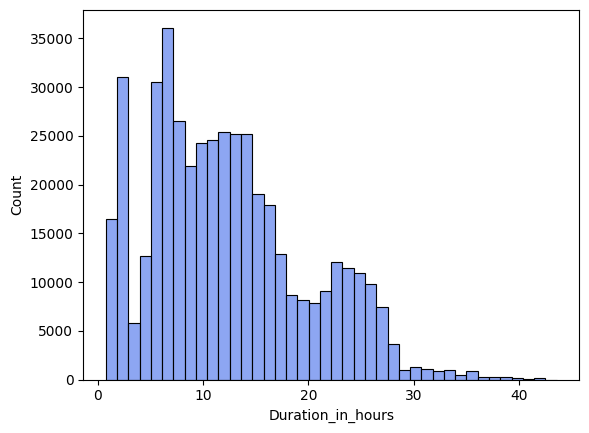

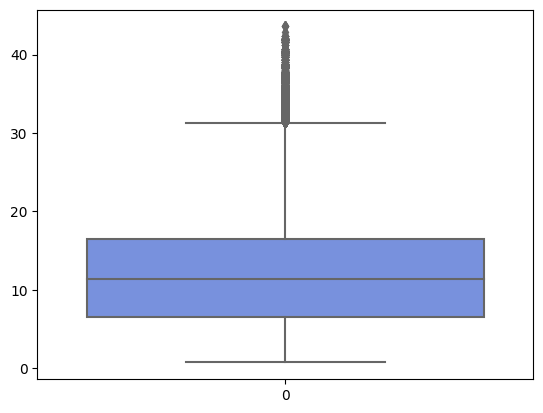

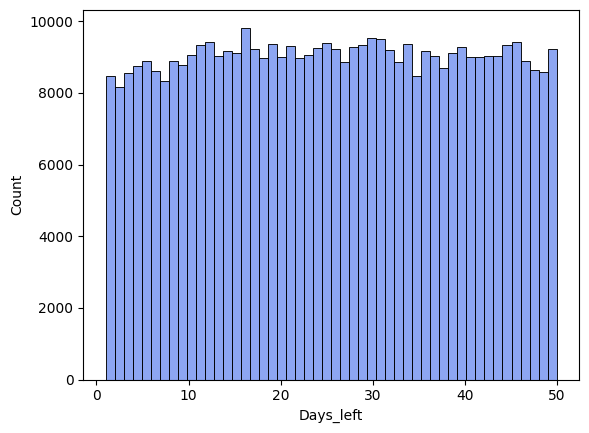

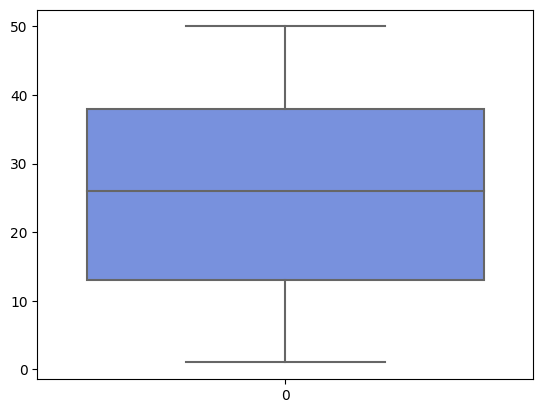

In [12]:
# Plot a histogram and boxplot for numerical variables
sns.histplot(df['Duration_in_hours'], bins=40)
plt.show()

sns.boxplot(df['Duration_in_hours'])
plt.show()

sns.histplot(df['Days_left'], bins=50)
plt.show()

sns.boxplot(df['Days_left'])
plt.show()


# Numerical Features Heatmap

The correlation heatmap reveals the following correlations between the features:
- 'Fare' exhibits a weak positive correlation (0.18) with 'Duration_in_hours'.
- There is a weak negative correlation (-0.09) between 'Fare' and 'Days_left'.

It's important to note that correlations between features can provide insights into potential relationships and they may not capture non-linear relationships between variables. Despite the weak negative correlation with 'Days_left', it is retained for training as it may still contribute to the predictive performance of the model through non-linear relationships.

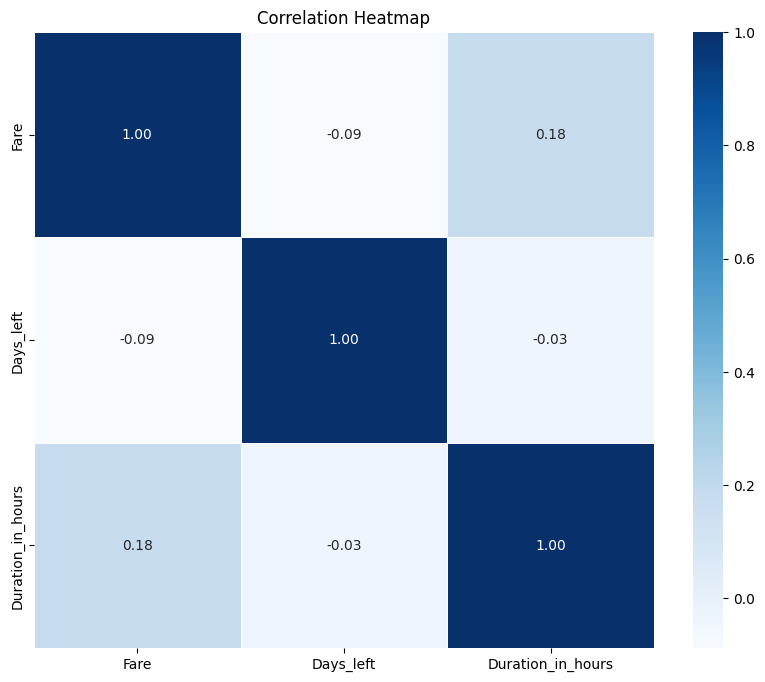

In [13]:
# Create a heatmap to visualize the correlations of numeric variables
correlation_matrix = df[['Fare', 'Days_left','Duration_in_hours']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Feature Engineering: Creating New Features

To enhance the predictive power of the model, new features were engineered based on preexisting ones.

## On_weekend Feature
A new binary feature, 'On_weekend', was created to indicate whether the journey day falls on a weekend. The distribution of this feature shows that the around 70% of flights occur on weekdays rather than weekends.

## Daytime_departure and Daytime_arrival Features
Two additional binary features, 'Daytime_departure' and 'Daytime_arrival', were introduced to capture whether the departure and arrival times are during the daytime or nighttime. It can be seen that most departures take time during the day, while arrivals are almost equally distributed.

0    False
1    False
2    False
3    False
4    False
Name: On_weekend, dtype: bool


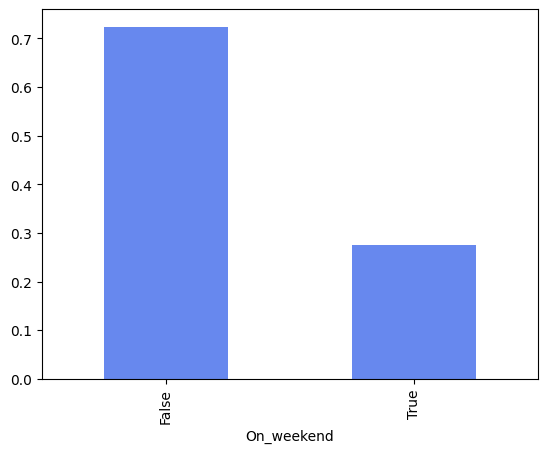

In [14]:
# Create new column 'On_weekend' 
df['On_weekend'] = False

for i, day in enumerate(df['Journey_day']):
    if day in ['Saturday', 'Sunday']:
        df.loc[i, 'On_weekend'] = True
        
print(df['On_weekend'].head())
df['On_weekend'].astype('category')

value_counts_weekend = df['On_weekend'].value_counts(normalize=True)
value_counts_weekend.plot(kind='bar')
plt.show()

0    False
1    False
2    False
3    False
4    False
Name: Daytime_departure, dtype: bool


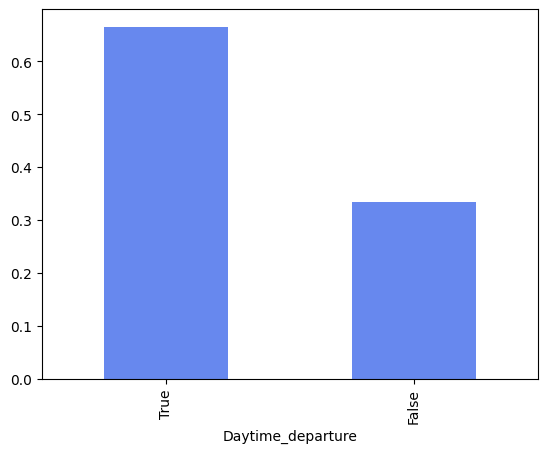

0    False
1    False
2    False
3    False
4    False
Name: Daytime_arrival, dtype: bool


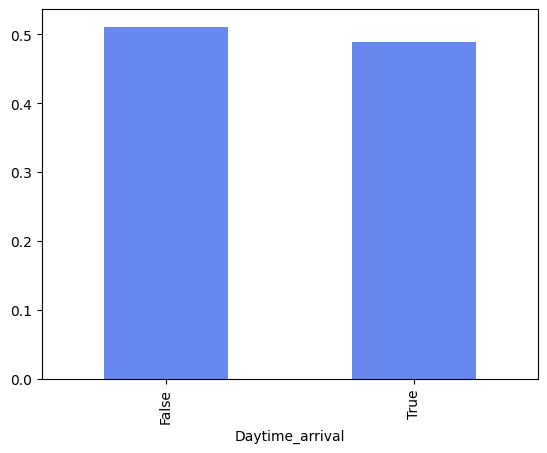

In [15]:
# Create new columns 'Daytime_departure' and 'Daytime_arrival'
df['Daytime_departure'] = True
overnight = ['After 6 PM', 'Before 6 AM']  

for i, time in enumerate(df['Departure']):
    if time in overnight:
        df.loc[i, 'Daytime_departure'] = False

print(df['Daytime_departure'].head())

value_counts_weekend = df['Daytime_departure'].value_counts(normalize=True)
value_counts_weekend.plot(kind='bar')
plt.show()

df['Daytime_arrival'] = True

for i, time in enumerate(df['Arrival']):
    if time in overnight:
        df.loc[i, 'Daytime_arrival'] = False

print(df['Daytime_arrival'].head())

value_counts_weekend = df['Daytime_arrival'].value_counts(normalize=True)
value_counts_weekend.plot(kind='bar')
plt.show()


In [16]:
# Split the data into training and testing sets
X = df.drop('Fare', axis=1)
y = df['Fare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True,stratify=X['Airline'])

## Choosing Transformers for Numerical Features

This step aims to explore and select appropriate transformers for numerical features in the dataset. Four different transformers were applied to the features 'Duration_in_hours' and 'Days_left': StandardScaler, RobustScaler, QuantileTransformer, and PowerTransformer.

The goal is to identify which transformers produce distributions that are closer to desired characteristics, such as normality or robustness to outliers. Based on the visualizations, suitable transformers are chosen for each feature: QuantileTransformer and RobustScaler for 'Duration_in_hours', and RobustScaler and QuantileTransformer for 'Days_left'.

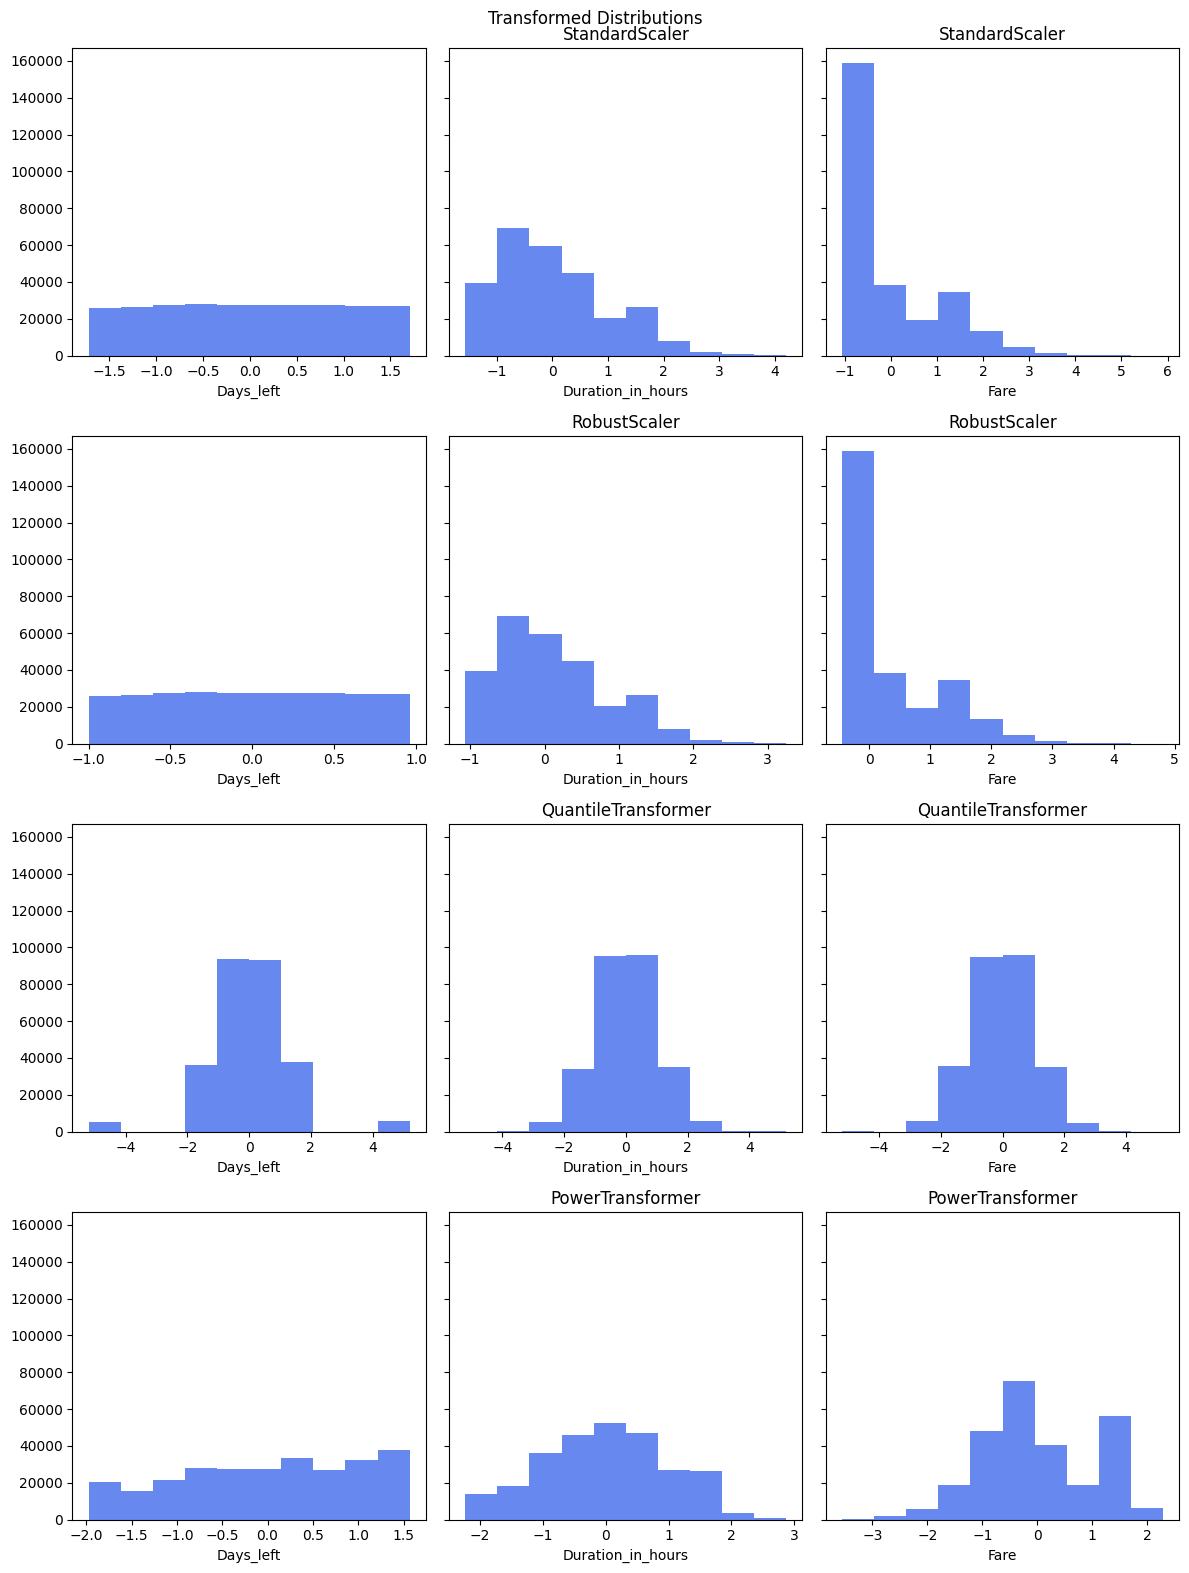

In [17]:
#Transform and plot numerical features to choose transformers for the pipeline
num_features = ['Duration_in_hours', 'Days_left']
transformers = [
    StandardScaler(),
    RobustScaler(),
    QuantileTransformer(output_distribution='normal', random_state=0),
    PowerTransformer(standardize=True)
]

fig, axs = plt.subplots(len(transformers), 3, figsize=[12, 4 * len(transformers)], sharey=True)
fig.suptitle("Transformed Distributions", fontsize=12)

for i, t in enumerate(transformers):
    transformation = t
    X_train_transformed = transformation.fit_transform(X_train[num_features])
    df_transformed = pd.DataFrame(X_train_transformed, columns=num_features)
    
    axs[i, 0].hist(df_transformed['Days_left'])
    axs[i, 0].set_xlabel('Days_left')
    
    axs[i, 1].hist(df_transformed['Duration_in_hours'])
    axs[i, 1].set_xlabel('Duration_in_hours')
    axs[i, 1].set_title(type(transformation).__name__)

    y_train_transformed = transformation.fit_transform(y_train.values.reshape(-1, 1))  # Reshape to 2D array
    df_y_transformed = pd.DataFrame(y_train_transformed, columns=['Fare'])
    
    axs[i, 2].hist(df_y_transformed['Fare'])
    axs[i, 2].set_xlabel('Fare')
    axs[i, 2].set_title(type(transformation).__name__)

plt.tight_layout()
plt.show()

## Modeling and evaluation stage

### Preprocessing steps

In this part of the project, firstly the target variable and features were preprocessed to ensure optimal performance of the machine learning model. The target variable, representing flight fares, was transformed using QuantileTransformer to achieve a normal distribution.

For the features, a preprocessing pipeline was defined to handle both numerical and categorical features. Numerical features like 'Duration_in_hours' and 'Days_left' are scaled using QuantileTransformer and RobustScaler respectively to mitigate the outliers found within the dataset. Categorical features re one-hot encoded to convert them into a format suitable for modeling.

### Pipeline Building and Hyperparameter Tuning

After defining the preprocessing steps, a pipeline is constructed, integrating the preprocessing steps with an XGBoost regressor. Hyperparameter tuning is performed using RandomizedSearchCV to find the optimal combination of hyperparameters, while utilizing available computational resources effectively. The performance metric used for evaluation is negative mean squared error - the best model is selected based on the lowest error score.

After fitting the RandomizedSearchCV object to the training data, the best model's performance and the corresponding hyperparameters are extracted.

In [18]:
# Transform the target variable
quant_transformer = QuantileTransformer(output_distribution='normal')
y_train_transformed = quant_transformer.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = quant_transformer.transform(y_test.values.reshape(-1, 1))

# Define the preprocessing steps
quant_transformer = QuantileTransformer(output_distribution='normal')
robust_scaler = RobustScaler()
one_hot_encoder = OneHotEncoder()

# Define categorical features
categorical_features = ['Journey_day', 'Airline', 'Class', 'Source', 'Departure', 'Total_stops',
                        'Arrival', 'Destination', 'On_weekend', 'Daytime_departure', 'Daytime_arrival']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('quant', quant_transformer, ['Duration_in_hours']),
        ('robust', robust_scaler, ['Days_left']),
        ('cat', one_hot_encoder, categorical_features)
    ],
    remainder='passthrough'
)

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [300,400,500],
    'regressor__learning_rate': [0.5],
    'regressor__max_depth': [10, 12],
    'regressor__subsample': [0.8, 0.9],
    'regressor__colsample_bytree': [0.8, 0.9],
    'regressor__min_child_weight': [15, 20],
    'regressor__reg_alpha': [0, 0.1, 0.5],
    'regressor__reg_lambda': [0, 0.1, 0.5],
}

# Define XGBoost regressor
xgb_regressor = XGBRegressor(random_state=73)

# Create pipeline for XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])

# Define and fit RandomizedSearchCV object
xgb_search = RandomizedSearchCV(xgb_pipeline,n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1, error_score='raise',param_distributions = param_grid)
xgb_search.fit(X_train, y_train_transformed)

# Get the best score and parameters
best_score = np.sqrt(-xgb_search.best_score_)
best_params_ = xgb_search.best_params_
print(f"XGBoost: {best_score}")
print("Best parameters for XGBoost:", best_params_)

XGBoost: 0.24916871371329727
Best parameters for XGBoost: {'regressor__subsample': 0.9, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 15, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.5, 'regressor__colsample_bytree': 0.8}


### Model Evaluation and Performance Metrics

After identifying the best-performing model through the hyperparameter search process, performance on test set was evaluated using metrics below:

- **Mean Squared Error (MSE):**
  - The average of the squared differences between predicted and actual values, which gives insight into the average squared deviation of predicted values from the actual values.

- **Root Mean Squared Error (RMSE):**
  - The square root of the MSE, which represents the standard deviation of the residuals and offers an interpretable measure in the same units as the target variable.

- **R-squared (R²) Score:**
  - A statistical measure that represents the proportion of variance explained by the model (on a 0-1 range). Contrary to the two previous metrics, here, higher values indicate better model fit to the data, with 1 being the perfect score.
   - The R² Score of 0.9434 indicates that approximately 94.34% of the variance in the target variable is explained by the model. This suggests that the model fits the data well and performs satisfactorily in predicting flight fares.
  
- **Mean Absolute Error (MAE):** 
  - This metric shows average absolute difference between the predicted and actual values. Unlike MSE and RMSE, MAE is less sensitive to outliers because it doesn't square the errors.
  
Overall, the obtained metrics suggest that our model performs well in predicting flight fares, with relatively low errors and high explanatory power.

Furthermore, it's worth noting that similar performance was observed on both the train and test sets, indicating no signs of overfitting and good generalization capability of the model.

In [20]:
# Retrieve the best model and predict on test data
best_model_xgb = xgb_search.best_estimator_
y_pred_test = best_model_xgb.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_transformed, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_transformed, y_pred_test)
mae = mean_absolute_error(y_test_transformed, y_pred_test)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Mean Absolute Error: 0.16302645800895518
Mean Squared Error: 0.05791084834593738
Root Mean Squared Error: 0.24064672934809933
R^2 Score: 0.9429748760289156


### Extraction of feature importances

The feature importances obtained from the model reveal the relative importance of each feature in predicting flight fares.

For example, the feature `cat__Class_Business` has the highest importance value of 0.359652, indicating that the class of the flight significantly impacts the predicted fare. This result aligns with our expectations, as business class fares are typically higher than economy class ones.

Additionally, features related to the number of stops in a flight itinerary, such as `cat__Total_stops_2+-stop` and `cat__Total_stops_1-stop`, also proved to have high importance in the model. This observation makes sense, since flights with more stops often indicate longer travel durations and may be associated with higher prices.

The top 10 features contributing to the model's predictions include:
1. `cat__Class_Business`
2. `cat__Total_stops_2+-stop`
3. `cat__Total_stops_1-stop`
4. `cat__Airline_Vistara`
5. `cat__Class_First`
6. `cat__Airline_Air India`
7. `cat__Source_Kolkata`
8. `cat__Destination_Kolkata`
9. `cat__Class_Economy`
10. `cat__Airline_AirAsia`

This suggests that the most influential categories to the model were class, number of stops, and airline. However, feature importances are based on the model's analysis and should be interpreted with caution, as they represent an estimation.

In [28]:
# Extract and print feature importances from the best model
X_train_transformed = preprocessor.fit_transform(X_train)
importances = best_model_xgb.named_steps['regressor'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                         Feature  Importance
15           cat__Class_Business    0.354893
32     cat__Total_stops_non-stop    0.125243
14          cat__Airline_Vistara    0.080284
31      cat__Total_stops_2+-stop    0.068379
30       cat__Total_stops_1-stop    0.065639
9         cat__Airline_Air India    0.033037
42      cat__Destination_Kolkata    0.028367
24           cat__Source_Kolkata    0.027191
16            cat__Class_Economy    0.017434
10          cat__Airline_AirAsia    0.014629
22             cat__Source_Delhi    0.013183
19         cat__Source_Ahmedabad    0.010809
12           cat__Airline_Indigo    0.009082
43       cat__Destination_Mumbai    0.007764
37    cat__Destination_Ahmedabad    0.007551
40        cat__Destination_Delhi    0.007362
38    cat__Destination_Bangalore    0.006857
29    cat__Departure_Before 6 AM    0.006850
1              robust__Days_left    0.006505
39      cat__Destination_Chennai    0.006257
21           cat__Source_Chennai    0.005837
20        

### Plot of Actual vs. Predicted Fares

The last plot compares the actual fares with the predicted fares generated by the model. Each point represents an observation, where the x-coordinate denotes the actual fare, and the y-coordinate represents the predicted fare. The diagonal dashed line indicates perfect predictions, where the actual and predicted fares are identical. 

The largest differences between actual and predicted fares are observed at the extremes of the fare scale, which suggests that the model tends to struggle more in accurately predicting fares at these extreme ends of the distribution.

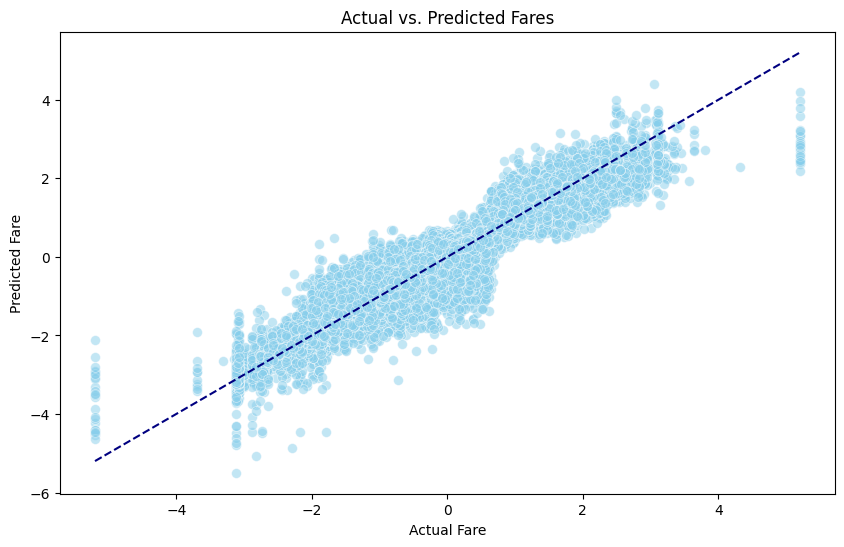

In [27]:
# Plot actual vs predicted fares
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_transformed.ravel(), y=y_pred_test.ravel(), color='skyblue', alpha=0.5, s=50)
plt.plot([min(y_test_transformed), max(y_test_transformed)], [min(y_test_transformed), max(y_test_transformed)], color='navy', linestyle='--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs. Predicted Fares")
plt.show()